#  Naive Bayes Classification for Sentiment Analysis on IMDB Movie Reviews

**Import the required library**

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


# Preprocessing data

**1. Reading dataset**

In [3]:
data_dir = 'aclImdb'

In [4]:
folders = [
    ('train', 'neg', 'negative'),
    ('train', 'pos', 'positive'),
    ('test', 'neg', 'negative'),
    ('test', 'pos', 'positive')
]
data = []

In [5]:
for split, sentiment, label in folders:
    folder_path = os.path.join(data_dir, split, sentiment)
    for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            text = file.read()
            data.append({ 'split': split, 'label': label,'text': text})
df = pd.DataFrame(data)


Data infor

In [6]:
print(df.tail())

      split     label                                               text
49995  test  positive  I was extraordinarily impressed by this film. ...
49996  test  positive  Although I'm not a golf fan, I attended a snea...
49997  test  positive  From the start of "The Edge Of Love", the view...
49998  test  positive  This movie, with all its complexity and subtle...
49999  test  positive  I've seen this story before but my kids haven'...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   split   50000 non-null  object
 1   label   50000 non-null  object
 2   text    50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


**Here are some samples of negative reviews in the test kit**

In [8]:
test_negative_reviews = df[(df['split'] == 'test') & (df['label'] == 'negative')]

In [9]:
test_negative_reviews.head()

,split,label,text
25000,test,negative,Once again Mr. Costner has dragged out a movie...
25001,test,negative,This is an example of why the majority of acti...
25002,test,negative,"First of all I hate those moronic rappers, who..."
25003,test,negative,Not even the Beatles could write songs everyon...
25004,test,negative,Brass pictures (movies is not a fitting word f...


 **2. Separate training and test sets:**

In [10]:
from sklearn.model_selection import train_test_split
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

 20% of the data will be selected as a test set and the remaining 80% will be  a training set.
 ran_state = 1 will return the same dataset when random the next time.
 

In [11]:
pd.DataFrame({'text':X_train,'Label':y_train}).head(10)

,text,Label
18165,The film version of Alice Walker's hugely emot...,positive
36059,I as a Christian am outraged after seeing just...,negative
13242,This movie will always be a Broadway and Movie...,positive
32985,Maybe being a government bureaucrat is not the...,negative
41133,A true masterpiece of the Soviet cinematograph...,positive
9273,This movie has such inexorable B class cheapne...,negative
12784,The first installment of this notorious horror...,positive
43992,"""Idiocracy"" is the latest film to come from Mi...",positive
33452,*Spoilers - sorry!* The first word that sprung...,negative
6342,I'm not saying that because the production val...,negative


**3. Transform text into a characteristic matrix**

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

this is the first 10 element of dict:

In [13]:
cnt = 0
for word,i in vectorizer.vocabulary_.items():
    print(f'{word} : {i}')
    cnt +=1
    if(cnt==10): break

the : 82288
film : 30347
version : 88246
of : 58174
alice : 3297
walker : 89329
hugely : 39630
emotive : 26794
and : 4095
influential : 41504


Create a vector whose size coincides with the frequency vector (dictionary), bearing the value 1 where it appears in the dictionary, and 0 if it does not appear

In [14]:
new_sentence = ["in an apartment"]  # Đặt chuỗi vào danh sách
new_sentence_vector = vectorizer.transform(new_sentence).toarray()
print(new_sentence_vector)


[[0 0 0 ... 0 0 0]]


It returns a sparse matrix where the elements corresponding to the words in the new sentence are 1, and the rest are 0. These are the non-zero elements in the vector.

In [14]:
nonZero = new_sentence_vector[new_sentence_vector !=0 ]
print(nonZero)

[1 1 1]


# 2. Naive Bayes model training

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# 假设 df 是加载的 IMDB 数据集，包含 'text' 和 'label' 列
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 TfidfVectorizer 提取特征，并移除停用词，同时设置 n-grams 范围
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 数据平衡：使用 RandomUnderSampler 进行下采样
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_tfidf, y_train)


# 定义多个分类模型并加入集成器
models = [
    ('MultinomialNB', MultinomialNB(alpha=0.1)),
    ('BernoulliNB', BernoulliNB(alpha=0.1)),
    ('ComplementNB', ComplementNB(alpha=0.1)),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
]

# 创建 VotingClassifier，使用软投票
ensemble_model = VotingClassifier(estimators=models, voting='soft')

# 训练集成模型
ensemble_model.fit(X_train_tfidf, y_train)

# 在测试集上进行预测
y_pred = ensemble_model.predict(X_test_tfidf)
y_pred_proba = ensemble_model.predict_proba(X_test_tfidf)

# 评估指标
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# 输出结果
print('--- Voting Classifier with Soft Voting ---')
print(f'Accuracy: {accuracy}')
print('F1 Score:', f1)
print('Classification Report:\n', report)

--- Voting Classifier with Soft Voting ---
Accuracy: 0.8849
F1 Score: 0.8847189469499229
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.92      0.89      5055
    positive       0.91      0.85      0.88      4945

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



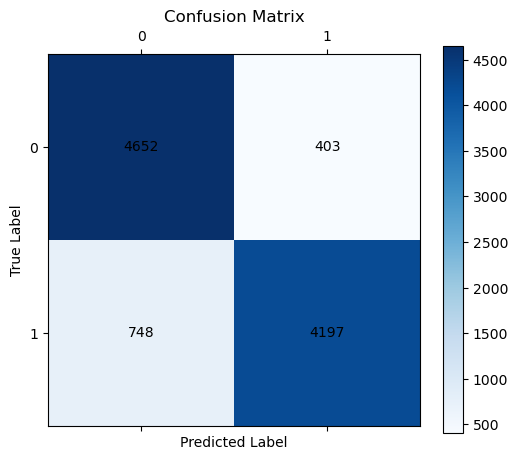

In [26]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

# 绘制带数字的混淆矩阵
plt.figure(figsize=(6, 5))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# 在每个方格中显示对应的数值
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

plt.show()

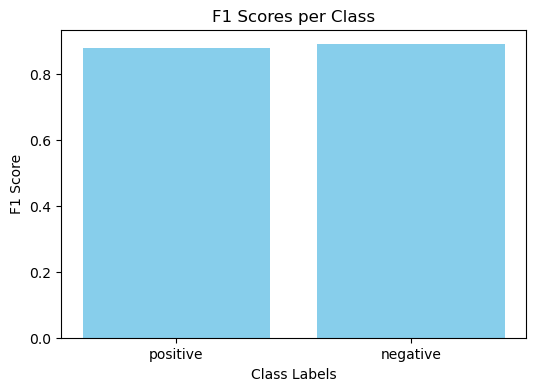

In [27]:

# 绘制 F1 得分条形图
f1_scores = classification_report(y_test, y_pred, output_dict=True)
f1_values = [f1_scores[str(label)]['f1-score'] for label in set(y_test)]
labels = list(set(y_test))

plt.figure(figsize=(6, 4))
plt.bar(labels, f1_values, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('F1 Score')
plt.title('F1 Scores per Class')
plt.show()

In [28]:
def predict_sentiment(text):
    # 使用训练好的 vectorizer 将文本转换为 TF-IDF 特征向量
    text_tfidf = vectorizer.transform([text])
    # 使用训练好的集成模型进行预测
    prediction = ensemble_model.predict(text_tfidf)[0]
    return "Positive" if prediction == 1 else "Negative"

# 示例：预测一条新的影评
new_review = "not bad"
print(f"Predicted sentiment is {predict_sentiment(new_review)}")


Predicted sentiment is Negative


In [ ]:
def test_individual_models(review_text):
    # 检查用户输入是否为空
    if not review_text.strip():
        print("输入为空，请输入有效的评论文本。")
        return
    
    # 将用户输入的文本转化为TF-IDF特征
    review_tfidf = vectorizer.transform([review_text])

    # 遍历每个单独模型，训练并预测
    for name, model in models:
        # 训练模型
        model.fit(X_train_tfidf, y_train)
        
        # 对用户评价进行预测
        prediction = model.predict(review_tfidf)
        prediction_proba = model.predict_proba(review_tfidf) if hasattr(model, "predict_proba") else None

        # 输出结果
        print(f"--- {name} ---")
        print("用户评价:", review_text)
        # 将预测结果转换为 positive 和 negative
        print("分类结果:", "正面评价" if prediction[0] == 'positive' else "负面评价")
        if prediction_proba is not None:
            print("预测概率:", [f"{p:.2f}" for p in prediction_proba[0]])  # 格式化概率输出为小数点后两位
        else:
            print("该模型不支持预测概率输出。")
        print("\n")


--- MultinomialNB ---
用户评价: This movie was absolutely fantastic! Great plot and amazing actors.
分类结果: 正面评价
预测概率: ['0.11', '0.89']


--- BernoulliNB ---
用户评价: This movie was absolutely fantastic! Great plot and amazing actors.
分类结果: 正面评价
预测概率: ['0.17', '0.83']


--- ComplementNB ---
用户评价: This movie was absolutely fantastic! Great plot and amazing actors.
分类结果: 正面评价
预测概率: ['0.11', '0.89']


--- Logistic Regression ---
用户评价: This movie was absolutely fantastic! Great plot and amazing actors.
分类结果: 正面评价
预测概率: ['0.12', '0.88']




In [34]:
# 示例测试
test_individual_models("This movie was absolutely fantastic! Great plot and amazing actors.")
test_individual_models("The movie was a complete waste of time. Terrible acting and a boring plot.")
test_individual_models("It was an average film. Not bad, but not great either.")
test_individual_models("Absolutely loved the film! One of the best I've seen in a while.")
test_individual_models("I wouldn't recommend it. The pacing was off, and the characters were shallow.")

--- MultinomialNB ---
用户评价: This movie was absolutely fantastic! Great plot and amazing actors.
分类结果: 正面评价
预测概率: ['0.11', '0.89']


--- BernoulliNB ---
用户评价: This movie was absolutely fantastic! Great plot and amazing actors.
分类结果: 正面评价
预测概率: ['0.17', '0.83']


--- ComplementNB ---
用户评价: This movie was absolutely fantastic! Great plot and amazing actors.
分类结果: 正面评价
预测概率: ['0.11', '0.89']


--- Logistic Regression ---
用户评价: This movie was absolutely fantastic! Great plot and amazing actors.
分类结果: 正面评价
预测概率: ['0.12', '0.88']


--- MultinomialNB ---
用户评价: The movie was a complete waste of time. Terrible acting and a boring plot.
分类结果: 负面评价
预测概率: ['1.00', '0.00']


--- BernoulliNB ---
用户评价: The movie was a complete waste of time. Terrible acting and a boring plot.
分类结果: 负面评价
预测概率: ['1.00', '0.00']


--- ComplementNB ---
用户评价: The movie was a complete waste of time. Terrible acting and a boring plot.
分类结果: 负面评价
预测概率: ['1.00', '0.00']


--- Logistic Regression ---
用户评价: The movie was a compl

--- Voting Classifier with Soft Voting ---
Accuracy: 0.8845
F1 Score: 0.8842973457578294
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.92      0.89      5055
    positive       0.91      0.85      0.88      4945

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



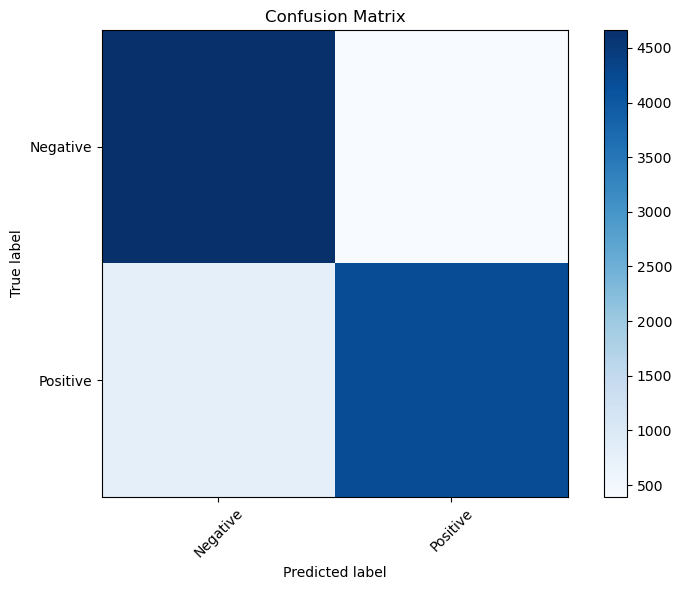

c:\Users\89556\.conda\envs\ML\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


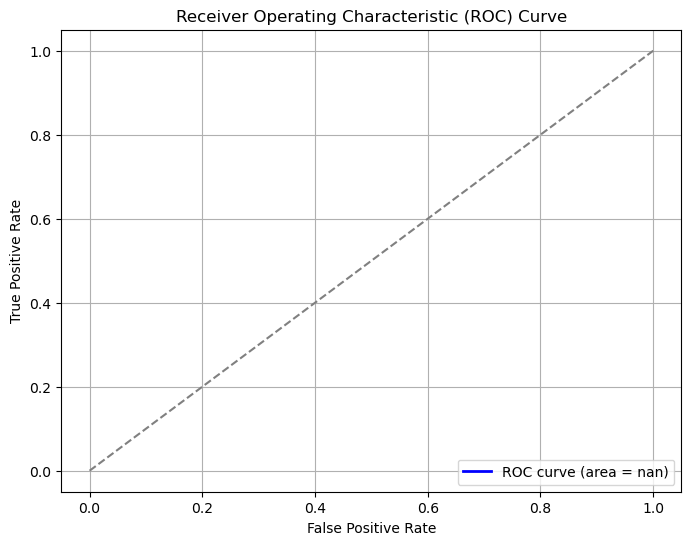

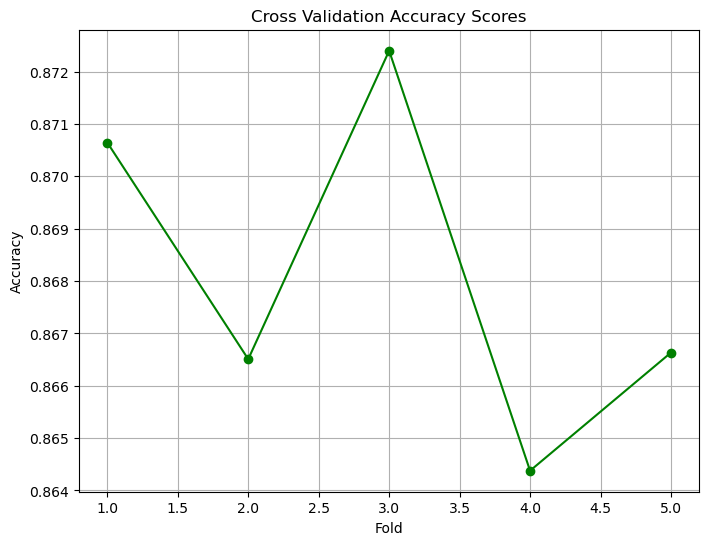

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# 假设 df 是加载的 IMDB 数据集，包含 'text' 和 'label' 列
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 TfidfVectorizer 提取特征，并移除停用词，同时设置 n-grams 范围
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 数据平衡：使用 RandomUnderSampler 进行下采样
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_tfidf, y_train)

# 定义多个分类模型并加入集成器
models = [
    ('MultinomialNB', MultinomialNB(alpha=0.1)),
    ('BernoulliNB', BernoulliNB(alpha=0.1)),
    ('ComplementNB', ComplementNB(alpha=0.1)),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
]

# 创建 VotingClassifier，使用软投票
ensemble_model = VotingClassifier(estimators=models, voting='soft')

# 训练集成模型
ensemble_model.fit(X_train_resampled, y_train_resampled)

# 在测试集上进行预测
y_pred = ensemble_model.predict(X_test_tfidf)
y_pred_proba = ensemble_model.predict_proba(X_test_tfidf)

# 评估指标
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# 输出结果
print('--- Voting Classifier with Soft Voting ---')
print(f'Accuracy: {accuracy}')
print('F1 Score:', f1)
print('Classification Report:\n', report)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# 计算并绘制 ROC 曲线
y_test_bin = label_binarize(y_test, classes=[0, 1])  # 将标签二值化
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 绘制准确率变化曲线
# 如果我们想要记录每次模型训练过程中准确率变化并绘制出来，可以通过交叉验证来跟踪这些结果：
cross_val_accuracies = cross_val_score(ensemble_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cross_val_accuracies) + 1), cross_val_accuracies, marker='o', color='green')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross Validation Accuracy Scores')
plt.grid(True)
plt.show()
